In [45]:
import pandas as pd
from pathlib import Path
import sys
import numpy as np
sys.path.append('../utils')
sys.path.append('..')
from EDA_utils import*
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# Data prep

In [46]:
data_folder_path = Path("../Datasets/Raw/Twi_2020")
new_format_data_path = Path("../Datasets/Raw/Twibot-20-new-format")
file_path_mean = '../Datasets/Processed/BERT_output/Tweets_mean_embedding.parquet'

df_tweets_mean = pd.read_parquet(file_path_mean)

In [47]:
neighbor_data_file = "edge.csv"
label_data_file = "label.csv"
profile_data_file = "node.part0.parquet"
# tweets_data_file = "Twi20_tweets.parquet"
split_data_file = "split.csv"

In [48]:
# domain_df = pd.read_parquet(old_format_data_path/domain_data_file)
neighbor_df = pd.read_csv(new_format_data_path/neighbor_data_file)
label_df = pd.read_csv(new_format_data_path/label_data_file)
profile_df = pd.read_parquet(new_format_data_path/profile_data_file)
split_df = pd.read_csv(new_format_data_path/split_data_file)

In [63]:
preprocessed_profile_df = (profile_df.pipe(profile_data_preprocessing,label_df=label_df, split_df=split_df, neighbor_df=neighbor_df))

c:\Users\maria\OneDrive\Documentos\Github\Twitter-Bot-Detction\4_Modeling\../utils\EDA_utils.py:57: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  created_at=lambda d: pd.to_datetime(d["created_at"]),  # Convert created_at to datetime


In [64]:
preprocessed_profile_df.head()

created_at  \
0 2008-11-18 10:27:25+00:00   
1 2020-08-23 07:35:11+00:00   
2 2008-11-27 18:47:32+00:00   
3 2008-08-06 15:12:10+00:00   
4 2013-08-10 03:25:35+00:00   

                                         description  \
0  VERY QUOTATIOUS, I PERFORM RANDOM ACTS OF SHAQ...   
1                                                      
2  Owner @ Parscale Strategy. Senior Advisor Digi...   
3  Bringing you the important stuff like breaking...   
4  MOTIVATION 3 OUT NOW 🔥 Singles: ‘Lil Shawdy’ &...   

                                            entities                    id  \
0  {'url': {'urls': [{'url': 'https://t.co/7hsiK8...             u17461978   
1                     {'description': {'urls': []}}   u1297437077403885568   
2  {'url': {'urls': [{'url': 'https://t.co/GooZcY...             u17685258   
3  {'url': {'urls': [{'url': 'https://t.co/RtP9QY...             u15750898   
4  {'url': {'urls': [{'url': 'https://t.co/5cY8GW...           u1659167666   

                  location                name  pinned_tweet_id  \
0             Orlando, FL                SHAQ               NaN   
1                            Jennifer Fishpaw               NaN   
2                 Florida       Brad Parscale               NaN   
3               Tampa, FL    FOX 13 Tampa Bay               NaN   
4  Jacksonville Beach, FL   Vonte The Plug 🎤🔌               NaN   

                                   profile_image_url protected  \
0  http://pbs.twimg.com/profile_images/1673907275...    False    
1  http://pbs.twimg.com/profile_images/1297437406...    False    
2  http://pbs.twimg.com/profile_images/1295453225...    False    
3  http://pbs.twimg.com/profile_images/1293193013...    False    
4  http://pbs.twimg.com/profile_images/1181662400...    False    

                                      public_metrics  ... following_count  \
0  {'followers_count': 15349596.0, 'following_cou...  ...           692.0   
1  {'followers_count': 0.0, 'following_count': 44...  ...            44.0   
2  {'followers_count': 762839.0, 'following_count...  ...           475.0   
3  {'followers_count': 327587.0, 'following_count...  ...          4801.0   
4  {'followers_count': 13324.0, 'following_count'...  ...           647.0   

  followers_follow_proportion listed_count  tweet_count  \
0                22181.465056      45568.0       9798.0   
1                    0.000000          0.0          0.0   
2                 1605.973461       3201.0       5518.0   
3                   68.233062       1744.0     192876.0   
4                   20.593477         44.0        103.0   

             reference_date  tenure  \
0 2020-09-05 13:59:15+00:00  4309.0   
1 2020-09-05 13:59:15+00:00    13.0   
2 2020-09-05 13:59:15+00:00  4299.0   
3 2020-09-05 13:59:15+00:00  4412.0   
4 2020-09-05 13:59:15+00:00  2583.0   

                                       follow_string followed_string  \
0                                                                      
1                                                          u18166778   
2  u1275068515666386945 u2535843469 u129365759103...                   
3  u855194021458739200 u1267566832598290432 u1290...                   
4  u893137540185718785 u1063858543 u26665819 u241...                   

                                       friend_string  random_number  
0                                                          0.596021  
1  u170861207 u23970102 u47293791 u29458079 u1799...       0.209064  
2  u46464108 u21536398 u18643437 u589490020 u1363...       0.918199  
3  u2324715174 u24030137 u2336676015 u192684124 u...       0.702505  
4  u1628313708 u726405625 u130868956 u26652768 u3...       0.574436  

[5 rows x 30 columns]

# Graph Feature Engineering

Here we are going to create features from graph data. We are going to use the method Bag of Words (BoW) also known as CountVectorizer.


***CountVectorizer*** - A tool provided by scikit-learn that converts text into a matrix of token counts, also known as a *bag of words*. Here's how it works:

- **Tokenization:** Splits the text into words, or "tokens," using a regular expression pattern that, by default, matches words of 2 or more alphanumeric characters (letters and numbers).

- **Normalization (optional):** By default, all tokens are converted to lowercase so that words like "Hello" and "hello" are treated as the same token. You can also specify a parameter to perform other forms of normalization.

- **Counting:** Counts how many times each token appears in each document.

- **Matrix Construction:** Builds a matrix where rows represent documents and columns represent tokens. Each cell in the matrix contains the count of a specific token in a specific document.

***Bag of Words (BoW)*** is a model used in natural language processing and information retrieval.

- In this model, a text is represented as a multiset of its words, disregarding grammar and even word order but maintaining multiplicity. Essentially, it represents text as a set of independent words.

How BoW works:

- **Vocabulary:** First, a vocabulary of known words is built from a set of documents. Each unique word across the entire set of documents forms the vocabulary.

- **Document Representation:** Each document is then represented by a vector with the same dimension as the vocabulary. Each element of the vector corresponds to a word in the vocabulary and is filled with the count of that word in the document.

--------------------------------------------------------------------------------

Example: Suppose we have a vocabulary formed by the words {cat, dog, barks, meows}, and two documents:

1. Document 1: "the cat meows"
2. Document 2: "the dog barks and the cat meows"

Each document would be represented by a 4-dimensional vector (corresponding to the number of words in the vocabulary):

- Vector for Document 1: [1, 0, 0, 1] 
  (cat appears once, dog does not appear, barks does not appear, meows appears once)
- Vector for Document 2: [1, 1, 1, 1] 
  (cat appears once, dog appears once, barks appears once, meows appears once)

--------------------------------------------------------------------------------

*Advantages of BoW:*

- **Simplicity:** Easy to understand and implement.
- **Efficiency:** Can be very efficient for analyses on large datasets.

*Disadvantages of BoW:*

- **Loss of Context:** Information about word order and grammar is lost, which can be crucial for understanding the meaning of a text.
- **Sparsity:** The resulting vector can be very large and mostly filled with zeros, especially if the vocabulary is large.
- **Sensitivity to Infrequent Words:** Rare words can distort the representation.


In [76]:
# Define the number of dimensions for TruncatedSVD
ndims = 10

# Create a feature engineering pipeline using ColumnTransformer
feature_eng_pipeline = ColumnTransformer(
    [
        # Apply CountVectorizer to the "followed_string" column
        ("vectorizer_followed", make_pipeline(CountVectorizer()), "followed_string"),
        # Apply CountVectorizer to the "follow_string" column
        ("vectorizer_follow", make_pipeline(CountVectorizer()), "follow_string"),
        # Apply CountVectorizer to the "friend_string" column
        ("vectorizer_friend", make_pipeline(CountVectorizer()), "friend_string")
    ]
)

# Extend the pipeline with TruncatedSVD for dimensionality reduction
feature_eng_pipeline = make_pipeline(feature_eng_pipeline, TruncatedSVD(3 * ndims))

# Alternative pipeline with a fixed number of dimensions for TruncatedSVD
# feature_eng_pipeline = make_pipeline(feature_eng_pipeline, TruncatedSVD(50))

# Pipeline with an SGDClassifier for inference
# inference_pipeline = make_pipeline(feature_eng_pipeline, SGDClassifier(loss = "log"))

In [30]:
#preprocessed_profile_df = pd.read_parquet(data_folder_path.parent/"preprocessed_features_with_graph_embeddings.parquet")

In [77]:
# Define a lambda function to create a mask for training data
train_mask = lambda d: d["split"] == "train"

# Define a lambda function to create a mask for test data
test_mask = lambda d: d["split"] == "test"

# Define a lambda function to create a mask for support data
support_mask = lambda d: d["split"] == "support"

# Define a lambda function to create a mask for validation data
val_mask = lambda d: d["split"] == "val"

# Define the target variable
target = "label"

# Display the count of each unique value in the 'label' column of the DataFrame
preprocessed_profile_df.label.value_counts()


label
bot      6589
human    5237
Name: count, dtype: int64

In [78]:
# Define a lambda function to create a mask for either training or support data
# This function returns True if the 'split' column value is either 'train' or 'support'
lambda d: (train_mask(d) | support_mask(d))

<function __main__.<lambda>(d)>

In [79]:
# Fit the feature engineering pipeline on the training and support data
feature_eng_pipeline.fit(preprocessed_profile_df[lambda d: (train_mask(d) | support_mask(d))])

# Uncomment these lines if you need to transform the entire DataFrame and extract the target labels
# X = feature_eng_pipeline.transform(preprocessed_profile_df)
# y = preprocessed_profile_df[target]

# Transform the entire DataFrame using the feature engineering pipeline
graph_embs = feature_eng_pipeline.transform(preprocessed_profile_df)


# Uncomment these lines if you need to create training, validation, and test datasets
# Extract target labels for the training data
# y_train = preprocessed_profile_df[train_mask][target]

# Transform the validation data using the feature engineering pipeline
# X_val = feature_eng_pipeline.transform(preprocessed_profile_df[val_mask])
# Extract target labels for the validation data
# y_val = preprocessed_profile_df[val_mask][target]

# Transform the test data using the feature engineering pipeline
# X_test = feature_eng_pipeline.transform(preprocessed_profile_df[test_mask])
# Extract target labels for the test data
# y_test = preprocessed_profile_df[test_mask][target]

# Uncomment to check the distribution of the 'split' column in the DataFrame
# preprocessed_profile_df.split.value_counts()

# Uncomment to view the subset of the DataFrame where the 'split' column is 'support'
# preprocessed_profile_df[lambda d: d.split == "support"]


In [70]:
graph_embs.shape

(229580, 30)

In [80]:
# Generate names for the embedding features
embs_names = (
    [f"followed_embs{i}" for i in range(ndims)] +
    [f"follow_embs{i}" for i in range(ndims)] +
    [f"friend_embs{i}" for i in range(ndims)]
)

# Add the generated embeddings to the DataFrame with the appropriate column names
preprocessed_profile_df[embs_names] = graph_embs

# Delete the temporary variable to free up memory
del graph_embs

In [81]:
preprocessed_profile_df.columns

Index(['created_at', 'description', 'entities', 'id', 'location', 'name',
       'pinned_tweet_id', 'profile_image_url', 'protected', 'public_metrics',
       'url', 'username', 'verified', 'withheld', 'label', 'split', 'follow',
       'friend', 'followed', 'followers_count', 'following_count',
       'followers_follow_proportion', 'listed_count', 'tweet_count',
       'reference_date', 'tenure', 'follow_string', 'followed_string',
       'friend_string', 'random_number', 'followed_embs0', 'followed_embs1',
       'followed_embs2', 'followed_embs3', 'followed_embs4', 'followed_embs5',
       'followed_embs6', 'followed_embs7', 'followed_embs8', 'followed_embs9',
       'follow_embs0', 'follow_embs1', 'follow_embs2', 'follow_embs3',
       'follow_embs4', 'follow_embs5', 'follow_embs6', 'follow_embs7',
       'follow_embs8', 'follow_embs9', 'friend_embs0', 'friend_embs1',
       'friend_embs2', 'friend_embs3', 'friend_embs4', 'friend_embs5',
       'friend_embs6', 'friend_embs7', 'frie

In [17]:
#preprocessed_profile_df.to_parquet(new_format_data_path.parent/"preprocessed_features_with_graph_embeddings.parquet")

In [82]:
df = preprocessed_profile_df
df.columns

Index(['created_at', 'description', 'entities', 'id', 'location', 'name',
       'pinned_tweet_id', 'profile_image_url', 'protected', 'public_metrics',
       'url', 'username', 'verified', 'withheld', 'label', 'split', 'follow',
       'friend', 'followed', 'followers_count', 'following_count',
       'followers_follow_proportion', 'listed_count', 'tweet_count',
       'reference_date', 'tenure', 'follow_string', 'followed_string',
       'friend_string', 'random_number', 'followed_embs0', 'followed_embs1',
       'followed_embs2', 'followed_embs3', 'followed_embs4', 'followed_embs5',
       'followed_embs6', 'followed_embs7', 'followed_embs8', 'followed_embs9',
       'follow_embs0', 'follow_embs1', 'follow_embs2', 'follow_embs3',
       'follow_embs4', 'follow_embs5', 'follow_embs6', 'follow_embs7',
       'follow_embs8', 'follow_embs9', 'friend_embs0', 'friend_embs1',
       'friend_embs2', 'friend_embs3', 'friend_embs4', 'friend_embs5',
       'friend_embs6', 'friend_embs7', 'frie

# Modelling

In [19]:
from lightgbm import LGBMClassifier

In [20]:
# model = LogisticRegression()
model = LGBMClassifier(n_estimators = 200, n_jobs = -1, learning_rate = 0.01)
model.fit(df[train_mask][embs_names], df[train_mask][target], eval_set = [(df[val_mask][embs_names], df[val_mask][target])])

[LightGBM] [Info] Number of positive: 3632, number of negative: 4646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.438753 -> initscore=-0.246223
[LightGBM] [Info] Start training from score -0.246223


LGBMClassifier(learning_rate=0.01, n_estimators=200, n_jobs=-1)

In [21]:
df["prediction"] = model.predict_proba(df[embs_names])[:,1]

In [22]:
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(df[train_mask][target], df[train_mask]["prediction"])
val_auc = roc_auc_score(df[val_mask][target], df[val_mask]["prediction"])
test_auc = roc_auc_score(df[test_mask][target], df[test_mask]["prediction"])

In [23]:
(train_auc, val_auc, test_auc)

(0.8610211450899927, 0.6191553462746407, 0.574330973756906)

In [ ]:
# !pip install pacmap
!pip install umap_learn -q

In [ ]:
# import pacmap
import umap
import matplotlib.pyplot as plt

# embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
embedding = umap.UMAP()

sample_df = df.sample(10_000)
# fit the data (The index of transformed data corresponds to the index of the original data)
embs = embedding.fit_transform(sample_df[embs_names])

sample_df[["umap0","umap1"]] = embs



<Axes: xlabel='umap0', ylabel='umap1'>

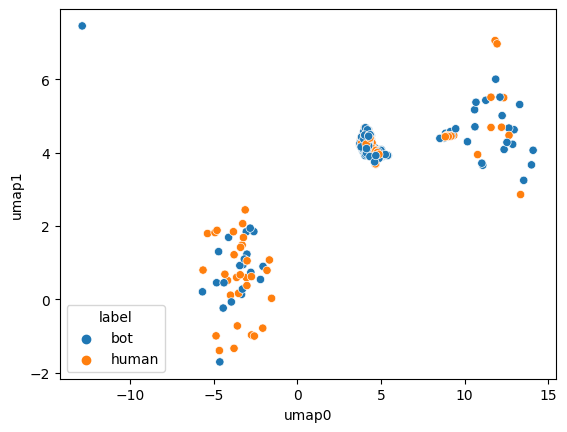

In [ ]:
# visualize the embedding
sns.scatterplot(data=sample_df, x="umap0", y="umap1", hue = "label")

<Axes: xlabel='umap0', ylabel='umap1'>

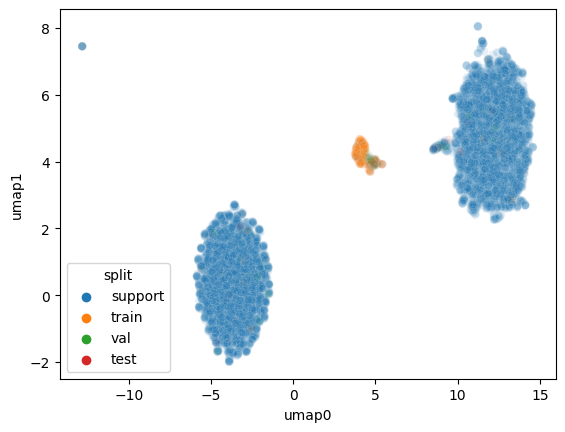

In [ ]:
sns.scatterplot(data=sample_df, x="umap0", y="umap1", hue = "split", alpha = 0.1)

<Axes: xlabel='umap0', ylabel='umap1'>

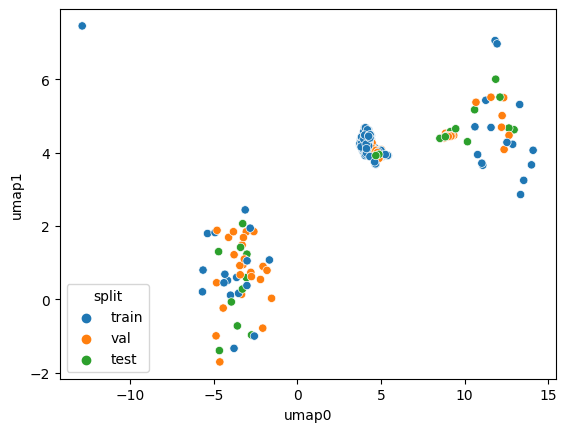

In [ ]:
sns.scatterplot(data=sample_df[lambda d: d.split != "support"], x="umap0", y="umap1", hue = "split")

# Evaluate distributional shift

# Feature Selection

In [ ]:
shap_values = model.predict(X_train, pred_contrib=True)
raw_preds = model.predict(X_train, raw_score=True)

shap_values_val = model.predict(X_val, pred_contrib=True)
raw_preds_val = model.predict(X_val, raw_score=True)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=10. Current value: min_data_in_leaf=10


In [ ]:
score_without_feature = pd.DataFrame(raw_preds.reshape(-1,1) - shap_values)
score_without_feature_val = pd.DataFrame(raw_preds_val.reshape(-1,1) - shap_values_val)

In [ ]:
auc = roc_auc_score(preprocessed_profile_df[train_mask][target], raw_preds)

error_contrib = score_without_feature.apply(
    lambda d: roc_auc_score(preprocessed_profile_df[train_mask][target], d)
  ) - auc

auc = roc_auc_score(preprocessed_profile_df[val_mask][target], raw_preds_val)

error_contrib_val = score_without_feature_val.apply(lambda d: roc_auc_score(preprocessed_profile_df[val_mask][target], d)) - auc

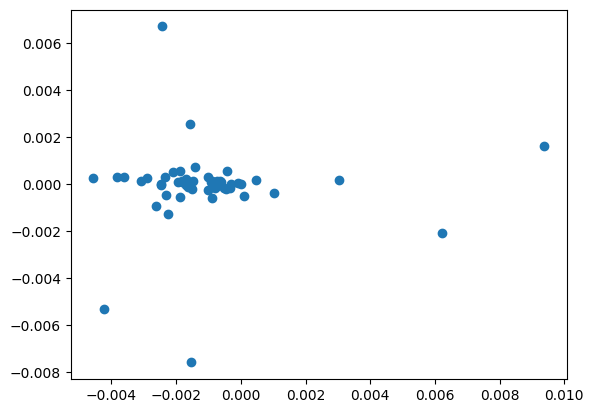

In [ ]:
plt.scatter(error_contrib, error_contrib_val)

## Code

In [ ]:
!pip install shap -q

In [ ]:
from toolz import curry

@curry
def fast_metric_with_ci_(data, *, n_samples=100, ci_level=0.95,
                     prediction='prediction', target='target', weight='weight', metric_fn = roc_auc_score):

    data = data.assign(weight=lambda df: df[weight] if weight is not None else 1)

    summary = (
        data
        .assign(
            prediction=lambda df: (1000 * df[prediction]).round(),
        )
        .groupby(["weight", 'prediction', target])
        .size().to_frame("sample_size")
        .reset_index()
    )

    estimate = (
        summary
        .assign(weight=lambda df: df["weight"] * df['sample_size'])
        .pipe(lambda df: metric_fn(df[target], df['prediction'], sample_weight=df['weight']))
    )

    bs_values = [
        summary
        .assign(weight=lambda df: df["weight"] * np.random.poisson(df['sample_size']))
        .pipe(lambda df: metric_fn(df[target], df['prediction'], sample_weight=df['weight']))
    for _ in range(n_samples)]

    lo, hi = bootstrap_ci(estimate, bs_values, ci_level=ci_level)

    return pd.Series(dict(
        estimate=estimate,
        ci_upper=hi,
        ci_lower=lo,
        model=prediction
    ))

@curry
def fast_auc_with_ci_sklearn(y_true, y_pred, *, sample_weight=None, n_samples=30, ci_level=0.95,):

    data = pd.DataFrame([y_true,y_pred], columns = ["target", "prediction"])
    if sample_weight is None:
      data["weight"] = 1
    else:
      data["weight"] = sample_weight

    return fast_auc_with_ci(data, n_samples=n_samples, ci_level=ci_level, prediction='prediction', target='defaulted', weight='weight', metric_fn = roc_auc_score)


def bootstrap_ci(sample_estimate, bootstrap_estimates, ci_level=0.95):
    lo = 2 * sample_estimate - np.quantile(bootstrap_estimates, (1 + ci_level) / 2)
    hi = 2 * sample_estimate - np.quantile(bootstrap_estimates, (1 - ci_level) / 2)
    return lo, hi



@curry
def fast_delta_metric_with_ci_(data, baseline, challenger, *, n_samples=100, ci_level=0.95,
                           target='target', weight='weight', metric_fn = roc_auc_score):

    data = data.assign(weight=lambda df: df[weight] if weight is not None else 1)

    summary = (
        data
        .assign(**{
            baseline: lambda df: (1000 * df[baseline]).round(),
            challenger: lambda df: (1000 * df[challenger]).round(),
        })
        .groupby(["weight", baseline, challenger, target])
        .size().to_frame("sample_size")
        .reset_index()
    )

    def delta_auc(df):
        challenger_auc = metric_fn(df[target], df[challenger], sample_weight=df['weight'])
        baseline_auc = metric_fn(df[target], df[baseline], sample_weight=df['weight'])
        return challenger_auc - baseline_auc

    estimate = (
        summary
        .assign(weight=lambda df: df["weight"] * df['sample_size'])
        .pipe(delta_auc)
    )

    bs_values = [
        summary
        .assign(weight=lambda df: df["weight"] * np.random.poisson(df['sample_size']))
        .pipe(delta_auc)
    for _ in range(n_samples)]

    lo, hi = bootstrap_ci(estimate, bs_values, ci_level=ci_level)

    return pd.Series(dict(
        estimate=estimate,
        ci_upper=hi,
        ci_lower=lo,
        model=challenger
    ))


@curry
def fast_delta_metric_with_ci(data, baseline, challengers, target, *, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score):

    fn = fast_delta_metric_with_ci_(
        baseline=baseline,
        n_samples=n_samples,
        ci_level=ci_level,
        target=target,
        weight=weight,
        metric_fn=metric_fn
      )

    all_values = [fn(data=data,challenger=c) for c in challengers]

    return pd.DataFrame(all_values)

@curry
def fast_metric_with_ci(data, predictions, target, *, n_samples=100, ci_level=0.95, weight='weight', metric_fn = roc_auc_score):

    fn = fast_metric_with_ci_(
        target=target,
        n_samples=n_samples,
        ci_level=ci_level,
        weight=weight,
        metric_fn=metric_fn
      )

    all_values = [fn(data=data,prediction=p) for p in predictions]

    return pd.DataFrame(all_values)

In [ ]:
from sklearn.base import clone



def backwards_shap_feature_selection(
    model,
    df_train,
    df_val,
    candidate_features_for_removal,
    target,
    null_hypothesis = "all_features_are_good"
    fixed_features=[],
    extra_validation_sets = {},
    sample_weight=None,
    metric_fn = roc_auc_score,
    n_samples=20,
    ci_level=0.8,
    max_iter = 10,
    patience=0,
    max_removals_per_run=None
):

  """
  """
  #TODO: implement two null hypothesis strategies. currently only "all_features_are_good"


  #check key names
  valid_nulls = ["all_features_are_bad","all_features_are_good"]
  if not null_hypothesis in valid_nulls:
      raise(ValueError(f"null_hypothesis should be one of {valid_nulls}, got {null_hypothesis}"))

  keys_intersections = set(extra_validation_sets.keys()) & set(candidate_features_for_removal + fixed_features)
  if keys_intersections:
    raise ValueError(f"extra_validation_sets names should not match names of features. Found {keys_intersections}")

  keys_intersections = keys_intersections & set(["metric", "error-contribution"])
  if keys_intersections:
    raise ValueError(f"extra_validation_sets names or feature names should not be 'metric' or 'error-contribution'. Found {keys_intersections}")

  all_logs = []
  p=0
  for i in range(max_iter):

    #set all features
    all_features = candidate_features_for_removal + fixed_features

    if len(all_features) == 0:
      break

    run_logs = _backwards_shap_feature_selection(
        model=clone(model),
        df_train=df_train,
        df_val=df_val,
        all_features=all_features,
        extra_validation_sets=extra_validation_sets,
        target=target,
        sample_weight=sample_weight,
        metric_fn=metric_fn,
        n_samples=n_samples,
        ci_level=ci_level,
    )

    if null_hypothesis == "feature_is_good":
      features_to_remove = (
          run_logs
          [lambda d: d["ci_lower"] > 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_lower", ascending=False)
      )
    else:
      features_to_remove = (
          run_logs
          [lambda d: d["ci_upper"] > 0]
          [lambda d: d["metric"] == "error-contribution"]
          [lambda d: ~d["model"].isin(fixed_features)]
          .sort_values(by = "ci_upper", ascending=False)
      )


    if max_removals_per_run is not None:
      features_to_remove = features_to_remove.iloc[:max_removals_per_run]

    features_to_remove = features_to_remove["model"].values.tolist() #model means the model without the feature

    run_logs["run_index"] = i
    run_logs["n_features"] = (run_logs["metric"] == "error-contribution").sum()
    run_logs["removed_features"] = str(features_to_remove)
    run_logs["n_features_removed"] = len(features_to_remove)
    all_logs.append(run_logs)

    if len(features_to_remove) == 0:
      if patience:
        if p >= patience:
          break
        else:
          p+=1
      else:
        break
    #update features for the next iteration
    candidate_features_for_removal = [i for i in candidate_features_for_removal if not i in features_to_remove]
    i+=1

  return pd.concat(all_logs, ignore_index=True)


def _backwards_shap_feature_selection(
    model,
    df_train,
    df_val,
    all_features,
    extra_validation_sets,
    target,
    sample_weight,
    metric_fn,
    n_samples,
    ci_level,
):

  #train model
  model.fit(
      df_train[all_features],
      df_train[target],
      sample_weight=sample_weight
  )


  #calculate shap
  explainer = shap.TreeExplainer(model)
  shap_values_val = explainer.shap_values(df_val[all_features])[-1]

  #make raw preds
  raw_preds_val = proba_to_log_odds(model.predict_proba(df_val[all_features])[:,-1])

  #score without feature
  scores_df = pd.DataFrame(
      log_odds_to_proba(raw_preds_val.reshape(-1,1) - shap_values_val),
      columns = all_features
  )

  #add extra columns
  scores_df["val_set"] = raw_preds_val
  scores_df[target] = df_val[target].values
  if sample_weight is not None:
    df_val[sample_weight].values


  #deltas
  error_contributions_with_ci = fast_delta_metric_with_ci(
      scores_df,
      baseline="val_set",
      challengers=all_features,
      n_samples=n_samples,
      ci_level=ci_level,
      target=target,
      weight=sample_weight,
      metric_fn = metric_fn
    ).assign(metric="error-contribution")

  #current setup auc
  metric = fast_metric_with_ci(
      scores_df,
      predictions=["val_set"],
      n_samples=n_samples,
      ci_level=ci_level,
      target=target,
      weight=sample_weight,
      metric_fn = metric_fn
    ).assign(metric="metric", used_features=str(all_fatures))

  extra_val_logs = []
  for k,d in extra_validation_sets.items():
    extra_val_logs.append(
        fast_metric_with_ci(
          d.assign(**{k:lambda d: model.predict_proba(d[all_features])[:,-1], "weight__":lambda d: d[sample_weight] if sample_weight is not None else 1}),
          predictions=[k],
          n_samples=n_samples,
          ci_level=ci_level,
          target=target,
          weight="weight__",
          metric_fn = metric_fn
      ).assign(metric="metric", used_features=str(all_fatures))
    )



  return pd.concat([error_contributions_with_ci,metric], ignore_index = True)

## Run feature selection

In [ ]:

fs_logs = backwards_shap_feature_selection(
    RandomForestClassifier(n_jobs = -1, min_samples_leaf = 5),
    df[train_mask],
    df[val_mask],
    candidate_features_for_removal = embs_names,
    target=target,
    fixed_features=[],
    sample_weight=None,
    metric_fn = roc_auc_score,
    n_samples=10,
    ci_level=0.60,
    max_iter=10,
    max_removals_per_run=None
)

[LightGBM] [Info] Number of positive: 2916, number of negative: 3665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.319811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 793833
[LightGBM] [Info] Number of data points in the train set: 6581, number of used features: 3122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443094 -> initscore=-0.228616
[LightGBM] [Info] Start training from score -0.228616


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


KeyboardInterrupt: ignored

In [ ]:
fs_logs[lambda d: d.model == "baseline_prediction"]

<Axes: xlabel='ci_lower', ylabel='Count'>

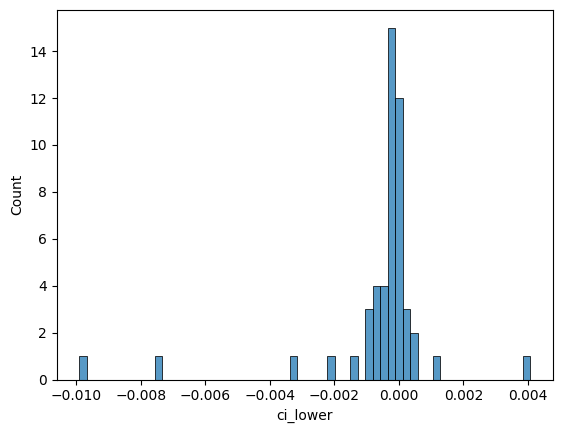

In [ ]:
import seaborn as sns
df_.pipe(sns.histplot, x="ci_lower")